# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import tempfile
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from io import BytesIO
from PIL import Image

from helpers import make_geoplot, make_market_plot, make_market_deep_dive_plot
from helpers import make_market_plot_multi_cell

In [3]:
# Initialize R instance
r = robjects.r

In [4]:
# Install the GeoLift package
r('''
if (!require("GeoLift")) {
    install.packages("GeoLift", repos="http://cran.us.r-project.org")
    library(GeoLift)
}
''')

R[write to console]: Loading required package: GeoLift



In [5]:
# Install the dplyr package (somewhat like pandas for R), used for Multi-Cell
r('''
if (!require("dplyr")) {
    install.packages("dplyr", repos="http://cran.us.r-project.org")
    library(dplyr)
}
''')

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Multi-Cell GeoLift Planning & Analysis

>Code based on walkthrough: https://facebookincubator.github.io/GeoLift/docs/GettingStarted/MultiCellWalkthrough/

## Determining # of Cells

In [6]:
r('''
# Load data
data(GeoLift_PreTest)

# Read into GeoLifts format with GeoDataRead
GeoTestData_PreTest <- GeoDataRead(data = GeoLift_PreTest,
                                    date_id = "date",
                                    location_id = "location",
                                    Y_id = "Y",
                                    X = c(), #empty list as we have no covariates
                                    format = "yyyy-mm-dd",
                                    summary = TRUE)
''')

R[write to console]: ##################################
#####       Summary       #####
##################################

* Raw Number of Locations: 40
* Time Periods: 90
* Final Number of Locations (Complete): 40



In [17]:
r('''
print(tail(GeoTestData_PreTest))
''')

       location time    Y
3595 washington   85 2258
3596 washington   86 3037
3597 washington   87 4453
3598 washington   88 3923
3599 washington   89 2144
3600 washington   90 1996


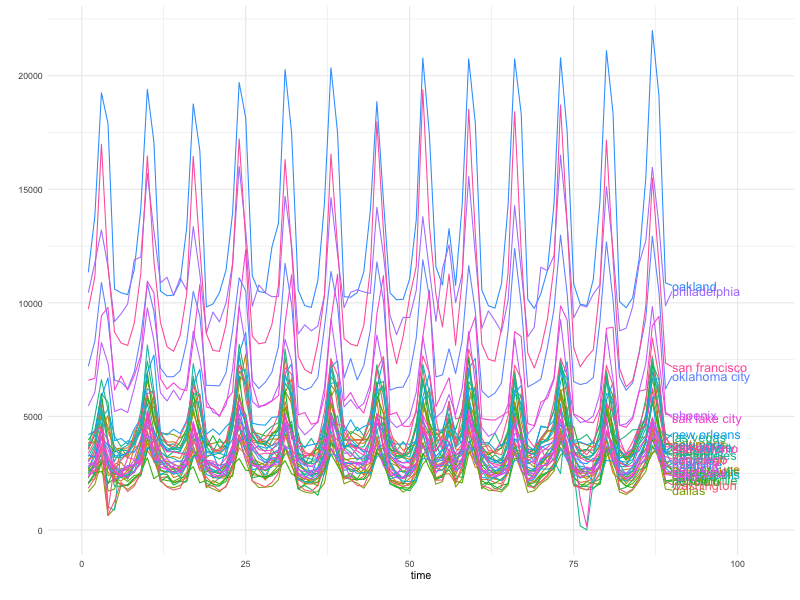

In [7]:
# Plot the KPI's historical values
p = "GeoPlot(GeoTestData_PreTest)"
make_geoplot(r, p)

## Finding test markets

In [14]:
# parameters documentation:
# https://facebookincubator.github.io/GeoLift/docs/GettingStarted/MultiCellWalkthrough/#2-finding-test-markets-with-multicellmarketselection

r('''
set.seed(8)  # to replicate the results
Markets <- MultiCellMarketSelection(data = GeoTestData_PreTest,
                                 k = 2,  # number of cells
                                 sampling_method = "systematic",
                                 top_choices = 10,
                                 N = c(2,3),
                                 effect_size = seq(0, 0.25, 0.025),
                                 treatment_periods = c(15),
                                 lookback_window = 1,
                                 cpic = c(7, 7.50),
                                 alpha = 0.1,
                                 model = "None",
                                 fixed_effects = TRUE,
                                 Correlations = TRUE,
                                 side_of_test = "one_sided",
                                 )
''')

In [15]:
r('''
print(Markets)
''')

   cell ID                            location duration EffectSize
1     1  1                 chicago, cincinnati       15      0.025
2     2  1                     baltimore, reno       15      0.025
3     1  2            cleveland, oklahoma city       15      0.050
4     2  2                       houston, reno       15      0.025
5     1  3               las vegas, saint paul       15      0.025
6     2  3              honolulu, indianapolis       15      0.025
7     1  4                nashville, san diego       15      0.025
8     2  4             houston, portland, reno       15      0.025
9     1  5               philadelphia, phoenix       15      0.025
10    2  5         denver, memphis, washington       15      0.050
11    1  6    cleveland, dallas, oklahoma city       15      0.025
12    2  6               baton rouge, portland       15      0.025
13    1  7               detroit, jacksonville       15      0.025
14    2  7                     denver, memphis       15      0

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



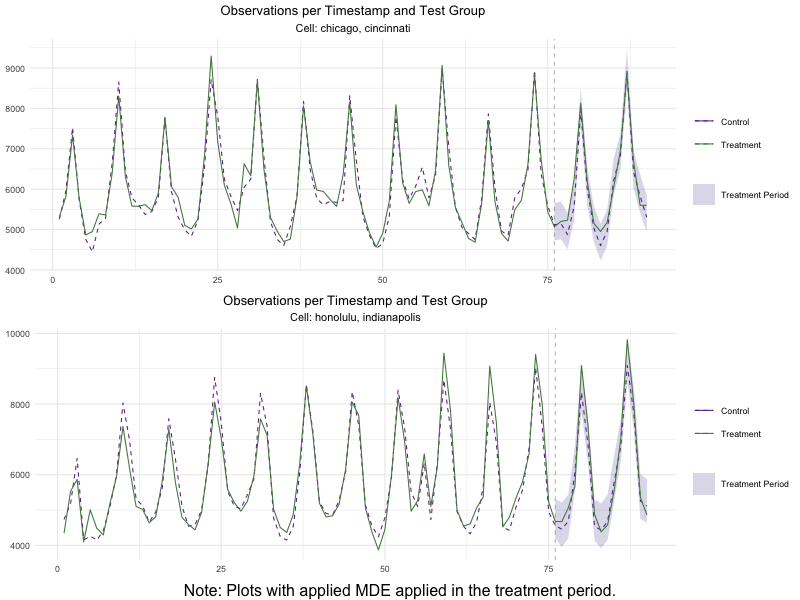

In [21]:
# # Cell and Market IDs in a list
# r('''
# test_locs <- list(cell_1 = 1, #chicago, cincinnati
#                   cell_2 = 3) #honolulu, indianapolis
# ''')

# p = '''
# plot(Markets,
#      test_markets = test_locs,
#      type = "Lift",
#      stacked = TRUE)
# '''

make_market_plot_multi_cell(r, 
                            [1,   # chicago, cincinnati
                             3],  # honolulu, indianapolis
                           )

## Detailed Power Curves